In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'

### Dependencies

In [0]:
!pip --quiet install efficientnet

In [5]:
from utillity_script_cloud_segmentation import *
import efficientnet.keras as efn

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/classification/'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_dest_path = 'train_images/'

### Load data

In [9]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
for label in label_columns:
  X_train[label].replace({0: 1, 1: 0}, inplace=True)
  X_val[label].replace({0: 1, 1: 0}, inplace=True)

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,1,1,1,0,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,1,1,0,0,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,0,0,1,1,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,1,1,0,1,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,0,0,0,0,train


# Model parameters

In [0]:
BATCH_SIZE = 64
WARMUP_EPOCHS = 5
WARMUP_LEARNING_RATE = 1e-3
EPOCHS = 30
LEARNING_RATE = 3e-4
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.2
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

model_name = '16-EfficientNetB0_%sx%s_Adam' % (HEIGHT, WIDTH)
model_path = model_base_path + '%s.h5' % (model_name)

### Data generator

In [32]:
datagen=ImageDataGenerator(rescale=1./255.,
                           vertical_flip=True,
                           horizontal_flip=True,
                           zoom_range=[1, 1.2],
                           fill_mode='constant',
                           cval=0.)

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                        dataframe=X_train,
                        directory=train_images_dest_path,
                        x_col="image",
                        y_col=label_columns,
                        target_size=(HEIGHT, WIDTH),
                        batch_size=BATCH_SIZE,
                        class_mode="other",
                        shuffle=True,
                        seed=seed)

valid_generator=test_datagen.flow_from_dataframe(
                             dataframe=X_val,
                             directory=train_images_dest_path,
                             x_col="image",
                             y_col=label_columns,
                             target_size=(HEIGHT, WIDTH),
                             batch_size=BATCH_SIZE,
                             class_mode="other",
                             shuffle=True,
                             seed=seed)

Found 4420 validated image filenames.
Found 1105 validated image filenames.


# Model

In [0]:
def create_model(input_shape, N_CLASSES):
    input_tensor = Input(shape=input_shape)
    base_model = efn.EfficientNetB0(weights='imagenet', 
                                    include_top=False,
                                    input_tensor=input_tensor, 
                                    pooling='avg')

    x = base_model.output
    final_output = Dense(N_CLASSES, activation='sigmoid')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [0]:
model = create_model((None, None, CHANNELS), N_CLASSES)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, verbose=1)

metric_list = ['accuracy']
callback_list = [checkpoint, es, rlrop]

## Warmup top layers

In [0]:
for layer in model.layers[:-1]:
  layer.trainable = False

optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metric_list)
# model.summary()

In [43]:
warmup_history = model.fit_generator(generator=train_generator,
                                      steps_per_epoch=STEP_SIZE_TRAIN,
                                      validation_data=valid_generator,
                                      validation_steps=STEP_SIZE_VALID,
                                      callbacks=callback_list,
                                      epochs=WARMUP_EPOCHS,
                                      verbose=1).history

Epoch 1/10
69/69 [==============================] - 77s 1s/step - loss: 0.6454 - acc: 0.6283 - val_loss: 0.6739 - val_acc: 0.5793
Epoch 2/10
69/69 [==============================] - 66s 963ms/step - loss: 0.6111 - acc: 0.6677 - val_loss: 0.6667 - val_acc: 0.5965
Epoch 3/10
69/69 [==============================] - 66s 956ms/step - loss: 0.5935 - acc: 0.6831 - val_loss: 0.6663 - val_acc: 0.5908
Epoch 4/10
69/69 [==============================] - 66s 954ms/step - loss: 0.5825 - acc: 0.6928 - val_loss: 0.6657 - val_acc: 0.5901
Epoch 5/10
69/69 [==============================] - 65s 945ms/step - loss: 0.5780 - acc: 0.6972 - val_loss: 0.6661 - val_acc: 0.5985
Epoch 6/10
69/69 [==============================] - 65s 935ms/step - loss: 0.5744 - acc: 0.6930 - val_loss: 0.6677 - val_acc: 0.5946

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/10
69/69 [==============================] - 63s 920ms/step - loss: 0.5670 - acc: 0.7046 - val_loss: 0.6622 - val_ac

## Fine-tune all layers

In [0]:
for layer in model.layers:
  layer.trainable = True

optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metric_list)
# model.summary()

In [46]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

Epoch 1/30
69/69 [==============================] - 115s 2s/step - loss: 0.5418 - acc: 0.7196 - val_loss: 0.5537 - val_acc: 0.7176
Epoch 2/30
69/69 [==============================] - 91s 1s/step - loss: 0.5023 - acc: 0.7483 - val_loss: 0.5372 - val_acc: 0.7322
Epoch 3/30
69/69 [==============================] - 91s 1s/step - loss: 0.4709 - acc: 0.7681 - val_loss: 0.5478 - val_acc: 0.7248
Epoch 4/30
69/69 [==============================] - 91s 1s/step - loss: 0.4490 - acc: 0.7855 - val_loss: 0.6176 - val_acc: 0.6926

Epoch 00004: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
Epoch 5/30
69/69 [==============================] - 93s 1s/step - loss: 0.4177 - acc: 0.8050 - val_loss: 0.5408 - val_acc: 0.7334
Epoch 6/30
69/69 [==============================] - 96s 1s/step - loss: 0.4000 - acc: 0.8179 - val_loss: 0.5470 - val_acc: 0.7329

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.2000000424450263e-05.
Epoch 7/30
69/69 [==============================] - 91s 

## Model loss graph

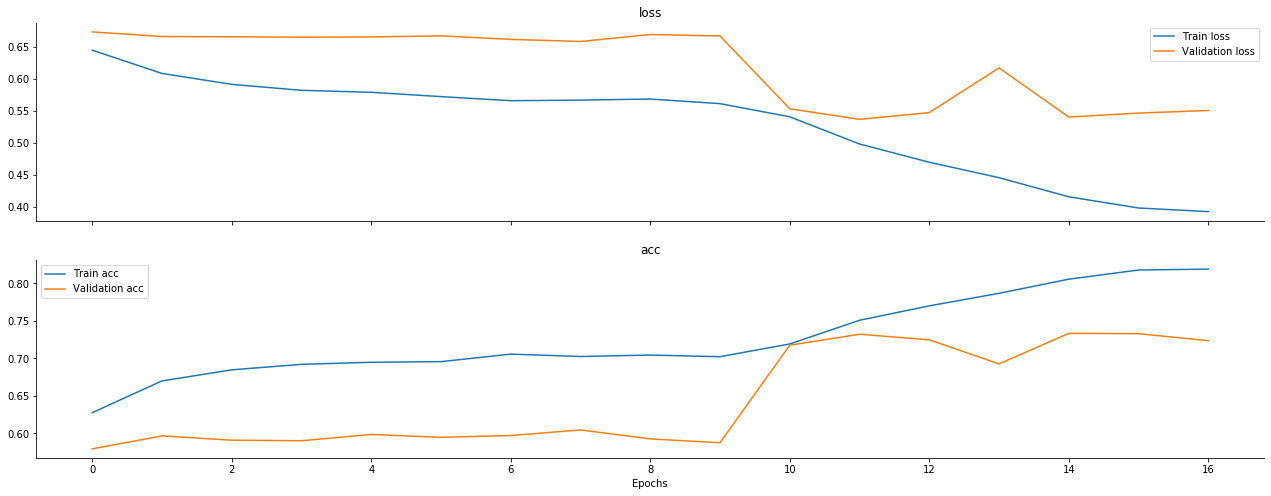

In [47]:
#@title
metrics_history = ['loss', 'acc']
for metric_hist in metrics_history:
  history[metric_hist] = warmup_history[metric_hist] + history[metric_hist]
  history['val_' + metric_hist] = warmup_history['val_' + metric_hist] + history['val_' + metric_hist]

plot_metrics(history, metric_list=metrics_history)